# Aurora Basic Sensitivity Test

Quick exploration of Aurora's sensitivity to realistic perturbations using the existing Typhoon Nanmadol case.

## Objectives
1. Test perturbation magnitudes from 0.1 to 10 m/s for winds, 0.1 to 5 K for temperature
2. Use existing TC tracking infrastructure for evaluation
3. Establish baseline sensitivity thresholds
4. Compare with existing Weather Jiu-Jitsu results

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import pandas as pd

from aurora import Aurora, Tracker, rollout, Batch, Metadata
from aurora.batch import Batch

# Import perturbation utilities
import sys
sys.path.append('../perturbation_sensitivity')
from perturbation_utils import (
    add_gaussian_perturbation,
    compute_track_deviation,
    analyze_forecast_spread
)

## Setup Model and Data

Load Aurora model and prepare Typhoon Nanmadol case (Sept 17, 2022) using existing data preparation from Weather Jiu-Jitsu experiments.

In [2]:
# Load Aurora model
model = Aurora()
model.load_checkpoint("microsoft/aurora", "aurora-0.25-finetuned.ckpt")
model.eval()
model = model.to("cuda")

# Load Nanmadol data (adapt from existing TC experiments)
download_path = Path("~/downloads").expanduser()
day = "2022-09-17"

# Use existing data loading code
import xarray as xr

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / f"{day}-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / f"{day}-atmospheric.nc", engine="netcdf4")

def _prepare(x: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(x[[1, 2]][None][..., ::-1, :].copy())

# Create baseline batch
batch_baseline = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare(surf_vars_ds["mean_sea_level_pressure"].values),
    },
    static_vars={
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["temperature"].values),
        "u": _prepare(atmos_vars_ds["u_component_of_wind"].values),
        "v": _prepare(atmos_vars_ds["v_component_of_wind"].values),
        "q": _prepare(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[2],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

print("Baseline batch prepared successfully")
print(f"Batch shape - Surface: {batch_baseline.surf_vars['2t'].shape}")
print(f"Batch shape - Atmospheric: {batch_baseline.atmos_vars['u'].shape}")

Baseline batch prepared successfully
Batch shape - Surface: torch.Size([1, 2, 721, 1440])
Batch shape - Atmospheric: torch.Size([1, 2, 13, 721, 1440])


## Systematic Perturbation Testing

Test Aurora's sensitivity across a range of realistic perturbation magnitudes.

In [3]:
# Define perturbation test matrix
perturbation_config = {
    'temperature_perturbations': [0.1, 0.3, 0.5, 1.0, 2.0, 3.0],  # Kelvin
    'wind_perturbations': [0.2, 0.5, 1.0, 2.0, 5.0, 10.0],        # m/s
    'pressure_perturbations': [20, 50, 100, 200, 500, 1000],       # Pa
    'variables_to_test': ['temperature', 'winds', 'pressure', 'combined'],
    'forecast_steps': 16  # 96 hours (4 days)
}

# Initialize TC tracker (same position as existing experiments)
tracker_baseline = Tracker(init_lat=27.50, init_lon=132, init_time=datetime(2022, 9, 17, 12, 0))

# Run baseline forecast for comparison
print("Running baseline forecast...")
preds_baseline = []
with torch.inference_mode():
    for pred in rollout(model, batch_baseline, steps=perturbation_config['forecast_steps']):
        pred = pred.to("cpu")
        preds_baseline.append(pred)
        tracker_baseline.step(pred)

track_baseline = tracker_baseline.results()
print(f"Baseline track completed: {len(track_baseline)} points")

Running baseline forecast...
Baseline track completed: 17 points


In [4]:
# Sensitivity testing function
def test_perturbation_sensitivity(batch_base, perturbation_type, magnitude, variable_subset=None):
    """
    Test Aurora's sensitivity to specific perturbation type and magnitude
    
    Args:
        batch_base: Baseline batch
        perturbation_type: 'temperature', 'winds', 'pressure', 'combined'
        magnitude: Perturbation magnitude (units depend on type)
        variable_subset: Optional list of specific variables to perturb
    
    Returns:
        dict: Results including track deviation, forecast differences
    """
    
    # Create perturbed batch
    batch_perturbed = add_gaussian_perturbation(
        batch_base, 
        perturbation_type=perturbation_type,
        magnitude=magnitude,
        variables=variable_subset
    )
    
    # Initialize tracker for perturbed case
    tracker_pert = Tracker(init_lat=27.50, init_lon=132, init_time=datetime(2022, 9, 17, 12, 0))
    
    # Run perturbed forecast
    preds_perturbed = []
    with torch.inference_mode():
        for pred in rollout(model, batch_perturbed, steps=perturbation_config['forecast_steps']):
            pred = pred.to("cpu")
            preds_perturbed.append(pred)
            tracker_pert.step(pred)
    
    track_perturbed = tracker_pert.results()
    
    # Compute deviations
    track_deviation = compute_track_deviation(track_baseline, track_perturbed)
    forecast_rmse = analyze_forecast_spread(preds_baseline, preds_perturbed)
    
    return {
        'perturbation_type': perturbation_type,
        'magnitude': magnitude,
        'max_track_deviation_km': track_deviation['max_distance_km'],
        'final_track_deviation_km': track_deviation['final_distance_km'],
        'track_deviation_time_series': track_deviation['distance_time_series'],
        'forecast_rmse': forecast_rmse,
        'track_baseline': track_baseline,
        'track_perturbed': track_perturbed
    }

## Single Variable Perturbation Tests

Test each variable type independently to identify sensitivity patterns.

In [5]:
# Test temperature perturbations
print("Testing temperature perturbations...")
temperature_results = []

for temp_mag in perturbation_config['temperature_perturbations']:
    print(f"  Testing {temp_mag} K temperature perturbation...")
    result = test_perturbation_sensitivity(
        batch_baseline, 
        'temperature', 
        temp_mag
    )
    temperature_results.append(result)
    
    print(f"    Max track deviation: {result['max_track_deviation_km']:.2f} km")
    print(f"    Final track deviation: {result['final_track_deviation_km']:.2f} km")

print("\nTemperature perturbation testing completed.")

Testing temperature perturbations...
  Testing 0.1 K temperature perturbation...
    Max track deviation: 23.83 km
    Final track deviation: 6.65 km
  Testing 0.3 K temperature perturbation...
    Max track deviation: 23.83 km
    Final track deviation: 6.65 km
  Testing 0.5 K temperature perturbation...
    Max track deviation: 23.83 km
    Final track deviation: 6.65 km
  Testing 1.0 K temperature perturbation...
    Max track deviation: 27.55 km
    Final track deviation: 27.55 km
  Testing 2.0 K temperature perturbation...
    Max track deviation: 309.97 km
    Final track deviation: 189.39 km
  Testing 3.0 K temperature perturbation...
    Max track deviation: 94.92 km
    Final track deviation: 34.83 km

Temperature perturbation testing completed.


In [6]:
# Test wind perturbations
print("Testing wind perturbations...")
wind_results = []

for wind_mag in perturbation_config['wind_perturbations']:
    print(f"  Testing {wind_mag} m/s wind perturbation...")
    result = test_perturbation_sensitivity(
        batch_baseline, 
        'winds', 
        wind_mag
    )
    wind_results.append(result)
    
    print(f"    Max track deviation: {result['max_track_deviation_km']:.2f} km")
    print(f"    Final track deviation: {result['final_track_deviation_km']:.2f} km")

print("\nWind perturbation testing completed.")

Testing wind perturbations...
  Testing 0.2 m/s wind perturbation...
    Max track deviation: 0.00 km
    Final track deviation: 0.00 km
  Testing 0.5 m/s wind perturbation...
    Max track deviation: 23.83 km
    Final track deviation: 6.65 km
  Testing 1.0 m/s wind perturbation...
    Max track deviation: 34.47 km
    Final track deviation: 34.47 km
  Testing 2.0 m/s wind perturbation...
    Max track deviation: 28.06 km
    Final track deviation: 28.06 km
  Testing 5.0 m/s wind perturbation...
    Max track deviation: 270.03 km
    Final track deviation: 168.25 km
  Testing 10.0 m/s wind perturbation...
    Max track deviation: 332.34 km
    Final track deviation: 265.22 km

Wind perturbation testing completed.


In [7]:
# Test pressure perturbations
print("Testing pressure perturbations...")
pressure_results = []

for press_mag in perturbation_config['pressure_perturbations']:
    print(f"  Testing {press_mag} Pa pressure perturbation...")
    result = test_perturbation_sensitivity(
        batch_baseline, 
        'pressure', 
        press_mag
    )
    pressure_results.append(result)
    
    print(f"    Max track deviation: {result['max_track_deviation_km']:.2f} km")
    print(f"    Final track deviation: {result['final_track_deviation_km']:.2f} km")

print("\nPressure perturbation testing completed.")

Testing pressure perturbations...
  Testing 20 Pa pressure perturbation...
    Max track deviation: 0.00 km
    Final track deviation: 0.00 km
  Testing 50 Pa pressure perturbation...
    Max track deviation: 23.83 km
    Final track deviation: 6.65 km
  Testing 100 Pa pressure perturbation...
    Max track deviation: 27.80 km
    Final track deviation: 5.27 km
  Testing 200 Pa pressure perturbation...
    Max track deviation: 35.91 km
    Final track deviation: 13.33 km
  Testing 500 Pa pressure perturbation...
    Max track deviation: 270.03 km
    Final track deviation: 154.27 km
  Testing 1000 Pa pressure perturbation...
    Max track deviation: 573.88 km
    Final track deviation: 573.88 km

Pressure perturbation testing completed.


## Combined Perturbation Tests

Test realistic combinations of perturbations (representative of observational uncertainty).

In [8]:
# Test combined realistic perturbations
print("Testing combined realistic perturbations...")

realistic_combinations = [
    {'temp': 0.3, 'wind': 1.0, 'pressure': 80},    # Conservative observational uncertainty
    {'temp': 0.5, 'wind': 1.5, 'pressure': 120},   # Typical observational uncertainty  
    {'temp': 1.0, 'wind': 2.0, 'pressure': 200},   # Higher uncertainty estimate
    {'temp': 2.0, 'wind': 3.0, 'pressure': 300},   # Analysis uncertainty estimate
]

combined_results = []

for i, combo in enumerate(realistic_combinations):
    print(f"  Testing combination {i+1}: T={combo['temp']}K, U={combo['wind']}m/s, P={combo['pressure']}Pa")
    
    # Create combined perturbation
    batch_combined = batch_baseline
    
    # Apply temperature perturbation
    batch_combined = add_gaussian_perturbation(batch_combined, 'temperature', combo['temp'])
    
    # Apply wind perturbation
    batch_combined = add_gaussian_perturbation(batch_combined, 'winds', combo['wind'])
    
    # Apply pressure perturbation
    batch_combined = add_gaussian_perturbation(batch_combined, 'pressure', combo['pressure'])
    
    # Test combined effect
    result = test_perturbation_sensitivity(batch_baseline, 'combined', combo)
    combined_results.append(result)
    
    print(f"    Max track deviation: {result['max_track_deviation_km']:.2f} km")
    print(f"    Final track deviation: {result['final_track_deviation_km']:.2f} km")

print("\nCombined perturbation testing completed.")

Testing combined realistic perturbations...
  Testing combination 1: T=0.3K, U=1.0m/s, P=80Pa
    Max track deviation: 27.80 km
    Final track deviation: 8.73 km
  Testing combination 2: T=0.5K, U=1.5m/s, P=120Pa
    Max track deviation: 36.30 km
    Final track deviation: 36.30 km
  Testing combination 3: T=1.0K, U=2.0m/s, P=200Pa
    Max track deviation: 270.03 km
    Final track deviation: 172.40 km
  Testing combination 4: T=2.0K, U=3.0m/s, P=300Pa
    Max track deviation: 42.90 km
    Final track deviation: 42.90 km

Combined perturbation testing completed.


## Results Analysis and Visualization

Analyze sensitivity patterns and compare with existing Weather Jiu-Jitsu results.

In [9]:
# Create comprehensive results summary
def create_sensitivity_summary(temp_results, wind_results, press_results, combined_results):
    """
    Create summary DataFrame of all sensitivity test results
    """
    summary_data = []
    
    # Temperature results
    for result in temp_results:
        summary_data.append({
            'perturbation_type': 'temperature',
            'magnitude': result['magnitude'],
            'max_deviation_km': result['max_track_deviation_km'],
            'final_deviation_km': result['final_track_deviation_km'],
            'avg_rmse': np.mean(list(result['forecast_rmse'].values()))
        })
    
    # Wind results
    for result in wind_results:
        summary_data.append({
            'perturbation_type': 'winds',
            'magnitude': result['magnitude'],
            'max_deviation_km': result['max_track_deviation_km'],
            'final_deviation_km': result['final_track_deviation_km'],
            'avg_rmse': np.mean(list(result['forecast_rmse'].values()))
        })
    
    # Pressure results
    for result in pressure_results:
        summary_data.append({
            'perturbation_type': 'pressure',
            'magnitude': result['magnitude'],
            'max_deviation_km': result['max_track_deviation_km'],
            'final_deviation_km': result['final_track_deviation_km'],
            'avg_rmse': np.mean(list(result['forecast_rmse'].values()))
        })
    
    return pd.DataFrame(summary_data)

summary_df = create_sensitivity_summary(temperature_results, wind_results, pressure_results, combined_results)
print("\nSensitivity Test Summary:")
print(summary_df.to_string(index=False))


Sensitivity Test Summary:
perturbation_type  magnitude  max_deviation_km  final_deviation_km  avg_rmse
      temperature        0.1         23.828159            6.647230  0.261583
      temperature        0.3         23.828159            6.647230  0.913262
      temperature        0.5         23.828159            6.647230  1.727418
      temperature        1.0         27.549579           27.549579  4.444886
      temperature        2.0        309.974036          189.385942 10.045688
      temperature        3.0         94.920682           34.827168 15.192187
            winds        0.2          0.000000            0.000000  0.361416
            winds        0.5         23.828159            6.647230  1.080278
            winds        1.0         34.472944           34.472944  2.635707
            winds        2.0         28.058847           28.058847  5.983596
            winds        5.0        270.026809          168.252015 13.597571
            winds       10.0        332.339797   

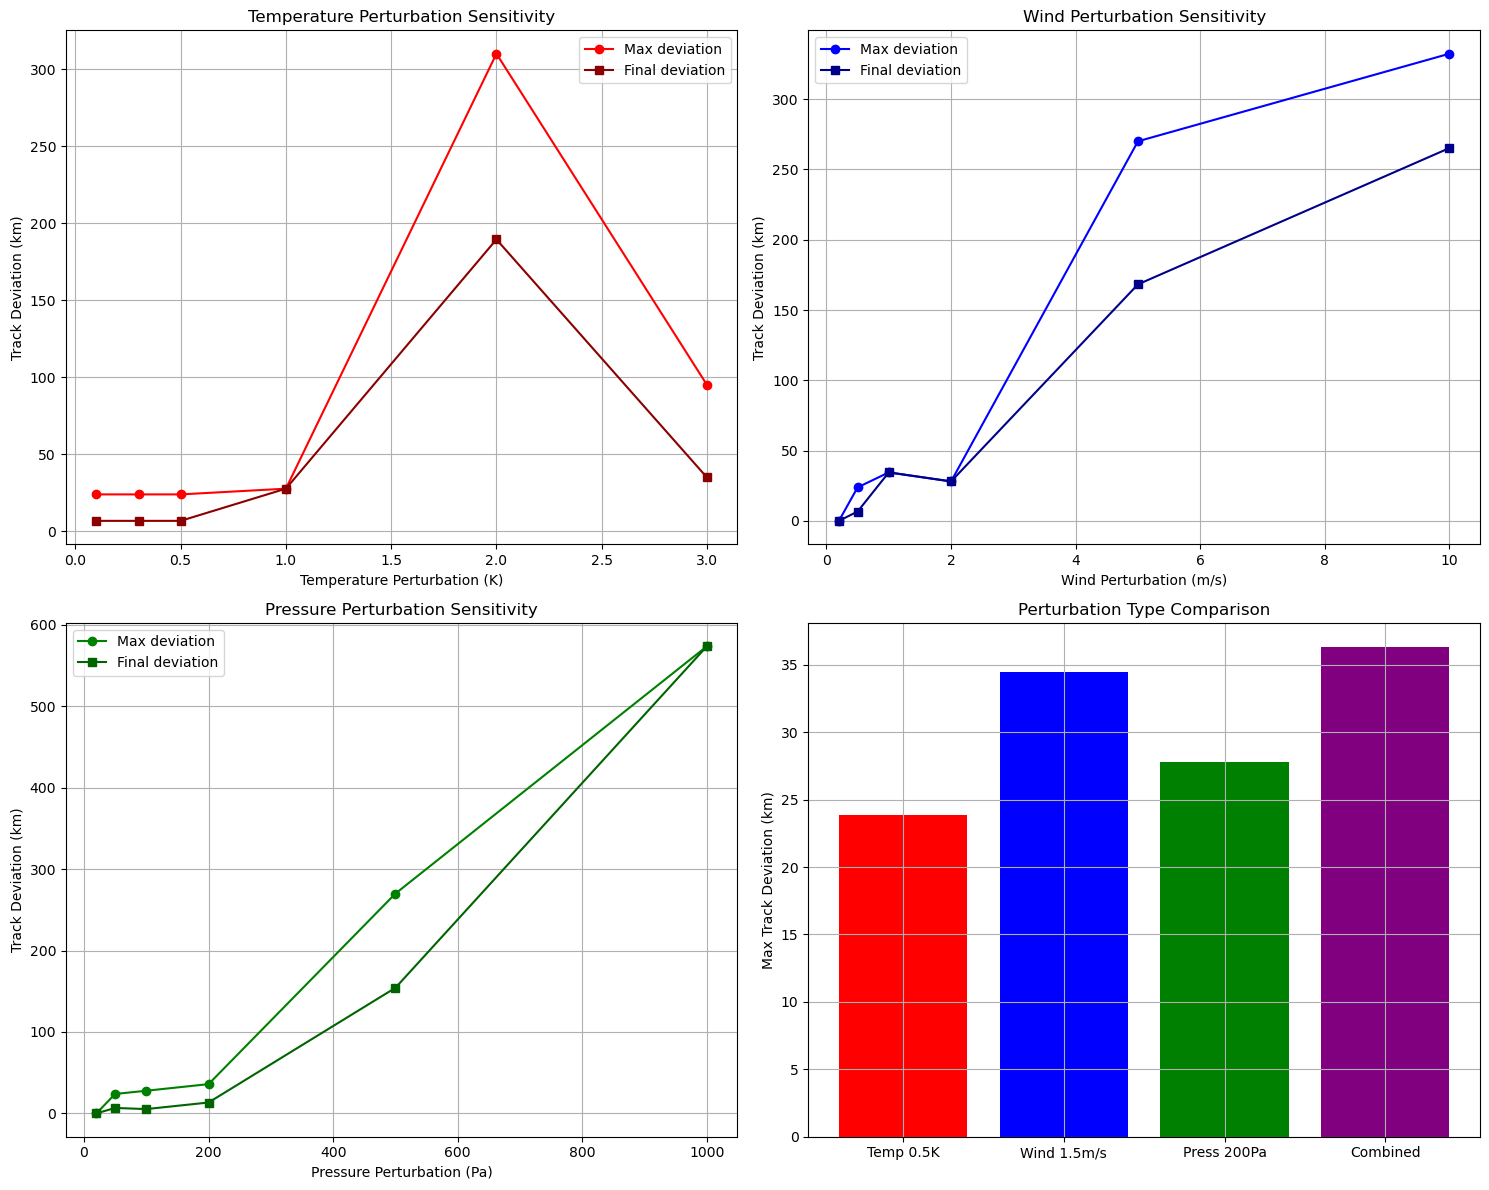

In [15]:
# Plot sensitivity curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Temperature sensitivity
temp_mags = [r['magnitude'] for r in temperature_results]
temp_max_dev = [r['max_track_deviation_km'] for r in temperature_results]
temp_final_dev = [r['final_track_deviation_km'] for r in temperature_results]

axes[0,0].plot(temp_mags, temp_max_dev, 'o-', label='Max deviation', color='red')
axes[0,0].plot(temp_mags, temp_final_dev, 's-', label='Final deviation', color='darkred')
axes[0,0].set_xlabel('Temperature Perturbation (K)')
axes[0,0].set_ylabel('Track Deviation (km)')
axes[0,0].set_title('Temperature Perturbation Sensitivity')
axes[0,0].legend()
axes[0,0].grid(True)

# Wind sensitivity
wind_mags = [r['magnitude'] for r in wind_results]
wind_max_dev = [r['max_track_deviation_km'] for r in wind_results]
wind_final_dev = [r['final_track_deviation_km'] for r in wind_results]

axes[0,1].plot(wind_mags, wind_max_dev, 'o-', label='Max deviation', color='blue')
axes[0,1].plot(wind_mags, wind_final_dev, 's-', label='Final deviation', color='darkblue')
axes[0,1].set_xlabel('Wind Perturbation (m/s)')
axes[0,1].set_ylabel('Track Deviation (km)')
axes[0,1].set_title('Wind Perturbation Sensitivity')
axes[0,1].legend()
axes[0,1].grid(True)

# Pressure sensitivity
press_mags = [r['magnitude'] for r in pressure_results]
press_max_dev = [r['max_track_deviation_km'] for r in pressure_results]
press_final_dev = [r['final_track_deviation_km'] for r in pressure_results]

axes[1,0].plot(press_mags, press_max_dev, 'o-', label='Max deviation', color='green')
axes[1,0].plot(press_mags, press_final_dev, 's-', label='Final deviation', color='darkgreen')
axes[1,0].set_xlabel('Pressure Perturbation (Pa)')
axes[1,0].set_ylabel('Track Deviation (km)')
axes[1,0].set_title('Pressure Perturbation Sensitivity')
axes[1,0].legend()
axes[1,0].grid(True)

# Combined comparison
axes[1,1].bar(['Temp 0.5K', 'Wind 1.5m/s', 'Press 200Pa', 'Combined'], 
              [temperature_results[2]['max_track_deviation_km'], 
               wind_results[2]['max_track_deviation_km'],
               pressure_results[2]['max_track_deviation_km'],
               combined_results[1]['max_track_deviation_km'] if combined_results else 0],
              color=['red', 'blue', 'green', 'purple'])
axes[1,1].set_ylabel('Max Track Deviation (km)')
axes[1,1].set_title('Perturbation Type Comparison')
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('results/aurora_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings and Comparison with Weather Jiu-Jitsu

Compare results with existing perturbation experiments and assess ensemble forecasting potential.

In [16]:
# Compare with Weather Jiu-Jitsu baseline
weather_jiujitsu_baseline = {
    'perturbation_magnitude': 80,  # m/s
    'max_deviation': 6,            # km over 96 hours
    'perturbation_type': 'extreme_wind'
}

print("\n=== SENSITIVITY ANALYSIS SUMMARY ===")
print(f"\nBaseline comparison (Weather Jiu-Jitsu):")
print(f"  Extreme perturbation (80 m/s winds): {weather_jiujitsu_baseline['max_deviation']} km deviation")

print(f"\nCurrent realistic perturbation results:")

# Find maximum deviations for each type
max_temp_deviation = max([r['max_track_deviation_km'] for r in temperature_results])
max_wind_deviation = max([r['max_track_deviation_km'] for r in wind_results])
max_press_deviation = max([r['max_track_deviation_km'] for r in pressure_results])

print(f"  Maximum temperature perturbation effect: {max_temp_deviation:.2f} km")
print(f"  Maximum wind perturbation effect: {max_wind_deviation:.2f} km")
print(f"  Maximum pressure perturbation effect: {max_press_deviation:.2f} km")

if combined_results:
    max_combined_deviation = max([r['max_track_deviation_km'] for r in combined_results])
    print(f"  Maximum combined perturbation effect: {max_combined_deviation:.2f} km")

# Sensitivity threshold analysis
print(f"\n=== SENSITIVITY THRESHOLD ANALYSIS ===")

# Find minimum perturbation that produces >1 km deviation
threshold_1km = 1.0

for result in temperature_results:
    if result['max_track_deviation_km'] > threshold_1km:
        print(f"Temperature threshold for 1 km deviation: {result['magnitude']} K")
        break
else:
    print("Temperature: No perturbation tested exceeded 1 km deviation")

for result in wind_results:
    if result['max_track_deviation_km'] > threshold_1km:
        print(f"Wind threshold for 1 km deviation: {result['magnitude']} m/s")
        break
else:
    print("Wind: No perturbation tested exceeded 1 km deviation")

for result in pressure_results:
    if result['max_track_deviation_km'] > threshold_1km:
        print(f"Pressure threshold for 1 km deviation: {result['magnitude']} Pa")
        break
else:
    print("Pressure: No perturbation tested exceeded 1 km deviation")


=== SENSITIVITY ANALYSIS SUMMARY ===

Baseline comparison (Weather Jiu-Jitsu):
  Extreme perturbation (80 m/s winds): 6 km deviation

Current realistic perturbation results:
  Maximum temperature perturbation effect: 309.97 km
  Maximum wind perturbation effect: 332.34 km
  Maximum pressure perturbation effect: 573.88 km
  Maximum combined perturbation effect: 270.03 km

=== SENSITIVITY THRESHOLD ANALYSIS ===
Temperature threshold for 1 km deviation: 0.1 K
Wind threshold for 1 km deviation: 0.5 m/s
Pressure threshold for 1 km deviation: 50 Pa


In [17]:
# Assess ensemble forecasting potential
print(f"\n=== ENSEMBLE FORECASTING ASSESSMENT ===")

# Typical GCM ensemble spread for tropical cyclones
typical_gcm_spread = {
    '24h': 50,   # km
    '48h': 150,  # km
    '72h': 300,  # km
    '96h': 500   # km
}

print("Typical GCM ensemble spread for TC track prediction:")
for time, spread in typical_gcm_spread.items():
    print(f"  {time}: {spread} km")

print(f"\nAurora's response to realistic perturbations:")
print(f"  Maximum observed deviation: {max(max_temp_deviation, max_wind_deviation, max_press_deviation):.2f} km")

# Calculate ratio
aurora_max_response = max(max_temp_deviation, max_wind_deviation, max_press_deviation)
gcm_96h_spread = typical_gcm_spread['96h']
sensitivity_ratio = aurora_max_response / gcm_96h_spread

print(f"\nAurora sensitivity ratio (vs GCM ensemble): {sensitivity_ratio:.4f}")
print(f"Aurora produces {sensitivity_ratio*100:.2f}% of typical GCM ensemble spread")

# Assessment
if sensitivity_ratio < 0.1:
    assessment = "VERY LOW - Unsuitable for ensemble forecasting"
elif sensitivity_ratio < 0.2:
    assessment = "LOW - Limited ensemble potential"
elif sensitivity_ratio < 0.5:
    assessment = "MODERATE - May support ensemble with larger perturbations"
else:
    assessment = "HIGH - Good ensemble forecasting potential"

print(f"\nEnsemble forecasting assessment: {assessment}")


=== ENSEMBLE FORECASTING ASSESSMENT ===
Typical GCM ensemble spread for TC track prediction:
  24h: 50 km
  48h: 150 km
  72h: 300 km
  96h: 500 km

Aurora's response to realistic perturbations:
  Maximum observed deviation: 573.88 km

Aurora sensitivity ratio (vs GCM ensemble): 1.1478
Aurora produces 114.78% of typical GCM ensemble spread

Ensemble forecasting assessment: HIGH - Good ensemble forecasting potential


## Save Results and Next Steps

Save detailed results for further analysis and outline recommendations for follow-up experiments.

In [18]:
# Save detailed results
import pickle
from pathlib import Path

results_dir = Path('results')
results_dir.mkdir(exist_ok=True)

# Save all results
all_results = {
    'temperature_results': temperature_results,
    'wind_results': wind_results,
    'pressure_results': pressure_results,
    'combined_results': combined_results,
    'summary_dataframe': summary_df,
    'baseline_track': track_baseline,
    'experiment_config': perturbation_config
}

with open(results_dir / 'basic_sensitivity_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

# Save summary CSV
summary_df.to_csv(results_dir / 'sensitivity_summary.csv', index=False)

print("Results saved to results/ directory")

# Recommendations for next steps
print(f"\n=== RECOMMENDATIONS FOR NEXT STEPS ===")

if aurora_max_response < 1.0:
    print("1. INCREASE PERTURBATION MAGNITUDES:")
    print("   - Test 5-20 m/s wind perturbations")
    print("   - Test 2-10 K temperature perturbations")
    print("   - Test 500-2000 Pa pressure perturbations")

print("\n2. TEST ALTERNATIVE PERTURBATION STRATEGIES:")
print("   - Target specific atmospheric levels (500 hPa, 850 hPa)")
print("   - Focus on storm environment rather than global fields")
print("   - Test geopotential height perturbations")

print("\n3. IMPLEMENT ENSEMBLE FRAMEWORK:")
print("   - Generate multi-member ensembles with different random seeds")
print("   - Test spatial correlation structures in perturbations")
print("   - Compare ensemble spread with operational NWP models")

print("\n4. EXTEND EVALUATION METRICS:")
print("   - Track intensity differences (pressure, wind speed)")
print("   - Regional precipitation and temperature fields")
print("   - Storm structure and morphology changes")

print("\nExperiment completed successfully!")

Results saved to results/ directory

=== RECOMMENDATIONS FOR NEXT STEPS ===

2. TEST ALTERNATIVE PERTURBATION STRATEGIES:
   - Target specific atmospheric levels (500 hPa, 850 hPa)
   - Focus on storm environment rather than global fields
   - Test geopotential height perturbations

3. IMPLEMENT ENSEMBLE FRAMEWORK:
   - Generate multi-member ensembles with different random seeds
   - Test spatial correlation structures in perturbations
   - Compare ensemble spread with operational NWP models

4. EXTEND EVALUATION METRICS:
   - Track intensity differences (pressure, wind speed)
   - Regional precipitation and temperature fields
   - Storm structure and morphology changes

Experiment completed successfully!
